Laboratorio 4

Práctica 4

Autores: Raúl Jiménez Juárez
         Beatriz Magán Pinto 
         David Alonso Rodríguez Lepina 
         Andrés Felipe Sánchez Patarroyo
         
Asignatura: Aprendizaje estadístico & Data Mining

Fecha: 23 de noviembre de 2019

Objetivo: Una empresa de importación de coches pretende hacer una renovación de sus instalaciones. Una de las propuestas es disponer de robots que permitan distribuir en los almacenes los coches de forma más eficiente. Para ello se dispone del archivo csv “cars” con las características de los distintos coches. Crear un modelo que agrupe los coches y establezca como se relacionan entre ellos jerárquicamente.

# importamos las librerias necesarias

In [1]:

import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from matplotlib import colors as mcolors 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
from matplotlib.patches import PathPatch
import seaborn as sns 
sns.set()

## Cargamos el dataset
el dataset de coches contiene las siguientes columnas:
    <ul>
    <li>symboling</li>
    <li>normalized-losses</li>
    <li>make</li>
    <li>fuel-type</li>
    <li>aspiration</li>
    <li>num-of-doors</li>
    <li>body-style</li>
    <li>drive-wheels</li>
    <li>engine-location</li>
    <li>wheel-base</li>
    <li>length</li>
    <li>width</li>
    <li>height</li>
    <li>curb-weight</li>
    <li>engine-type</li>
    <li>num-of-cylinders</li>
    <li>engine-size</li>
    <li>fuel-system</li>
    <li>bore</li>
    <li>stroke</li>
    <li>compression-ratio</li>
    <li>horsepower</li>
    <li>city-mpg</li>
    <li>highway-mpg</li>
    </ul>
En resumen, consideramos 3 tipos de datos relevantes para cada vehiculo:
<ol>
    <li>economicos: relacionados con el precio del coche y su posible perdida de valor</li>
    <li>fisicos: apariencia del vehiculo (estas caracteristicas pueden afectar tanto el precio del vehiculo como su funcionamiento) entre ellos se encuentran el alto, ancho y largo, tipo de carroceria, entre otros.</li>
    <li>tecnicos: aspectos del funcionamiento del coche (como el tipo de motor, tipo de combustible, etc.)</li>
</ol>

In [2]:
df_cars = pd.read_csv('RecursosLab4/cars.csv',na_values ='?')
pd.options.display.max_columns = None
print(len(df_cars))
df_cars.head()

164


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
1,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0
2,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,15250.0
3,1,158.0,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,17710.0
4,1,NaN,audi,gas,std,four,wagon,fwd,front,105.8,192.7,71.4,55.7,2954,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,18920.0


## Revisamos los valores faltantes
A partir del problema, se pretende eliminar la menor cantidad posible de registros en el dataset, es por ello que se revisarán los datos en búsqueda de datos faltantes y sus cantidades en cada columna, para poder decidir que se hará con estos registros o columnas incompletas

In [3]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 26 columns):
symboling            164 non-null int64
normalized-losses    134 non-null float64
make                 164 non-null object
fuel-type            164 non-null object
aspiration           164 non-null object
num-of-doors         162 non-null object
body-style           164 non-null object
drive-wheels         164 non-null object
engine-location      164 non-null object
wheel-base           164 non-null float64
length               164 non-null float64
width                164 non-null float64
height               164 non-null float64
curb-weight          164 non-null int64
engine-type          164 non-null object
num-of-cylinders     164 non-null object
engine-size          164 non-null int64
fuel-system          164 non-null object
bore                 164 non-null float64
stroke               164 non-null float64
compression-ratio    164 non-null float64
horsepower           162 non-

Como podemos observar, la columna <b>"normalized-losses"</b> tiene cerca de <b>30</b> valores faltantes, se completaran los datos a partir del promedio, "num-of-doors" tiene dos datos faltantes, por lo que serán completados con "four" puesto que es mas probable que ese sea el número de puertas, respecto a las variables "horsepower" y "peak-rpm" eliminamos los registros con datos faltantes, ya varían bastante entre un coche y otro, por último, el precio ("price") debería ser uno de los atributos más importantes a la hora de agrupar los coches, por lo que también se eliminarán estos registros.

In [4]:
df_cars.fillna(value={'normalized-losses':df_cars[['normalized-losses']].mean(axis=0).values[0],'num-of-doors':'four'}, inplace=True)
df_cars.dropna(subset=['horsepower','peak-rpm','price'], inplace=True)


## Transfomación de valores
para estos casos, tenemos valores categoricos que en realidad representan valores numericos ("two", "four", etc.) por lo que reemplazaremos estos datos por su representación numerica.

In [5]:
print(df_cars['num-of-cylinders'].unique())
print(df_cars['num-of-doors'].unique())
number_dict={'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'nine':9,'zero':0}
for i in ['one','two','three','four','five','six','seven','eight','nine','zero']:
    df_cars.loc[df_cars['num-of-cylinders'] == i,'num-of-cylinders']=number_dict[i]
    df_cars.loc[df_cars['num-of-doors'] == i,'num-of-doors']=number_dict[i]
print(df_cars['num-of-cylinders'].unique())
print(df_cars['num-of-doors'].unique())

['four' 'five' 'six' 'three' 'eight']
['four' 'two']
[4 5 6 3 8]
[4 2]


C:\Users\Acer\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [6]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 163
Data columns (total 26 columns):
symboling            160 non-null int64
normalized-losses    160 non-null float64
make                 160 non-null object
fuel-type            160 non-null object
aspiration           160 non-null object
num-of-doors         160 non-null int64
body-style           160 non-null object
drive-wheels         160 non-null object
engine-location      160 non-null object
wheel-base           160 non-null float64
length               160 non-null float64
width                160 non-null float64
height               160 non-null float64
curb-weight          160 non-null int64
engine-type          160 non-null object
num-of-cylinders     160 non-null int64
engine-size          160 non-null int64
fuel-system          160 non-null object
bore                 160 non-null float64
stroke               160 non-null float64
compression-ratio    160 non-null float64
horsepower           160 non-nu

## Transformación de variables categoricas
ya que utilizaremos distancias para realizar los clusters, transformaremos las variables categóricas a numéricas.

In [7]:
le = preprocessing.LabelEncoder()
cols=list(df_cars.select_dtypes(include='object').columns)
atributos=[]
df_cars.reset_index(drop = True, inplace=True) 
df_cars_norm=df_cars.copy()
#transformación de variables categoricas a numericas (se exige para utilizar los metodos de Naive Bayes)
for i in cols:
    df_cars_norm[i]=le.fit_transform(df_cars[i])
    #guardamos los atributos categoricos
    atributos.append(list(le.classes_))
display(df_cars_norm.head())

#estandarización de datos
names = df_cars_norm.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df_cars_norm)
df_cars_norm = pd.DataFrame(scaled_df, columns=names)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,2,164.000000,0,1,0,4,3,1,0,99.8,176.6,66.2,54.3,2337,2,4,109,4,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
1,2,164.000000,0,1,0,4,3,0,0,99.4,176.6,66.4,54.3,2824,2,5,136,4,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0
2,2,119.962687,0,1,0,2,3,1,0,99.8,177.3,66.3,53.1,2507,2,5,136,4,3.19,3.4,8.5,110.0,5500.0,19,25,15250.0
3,1,158.000000,0,1,0,4,3,1,0,105.8,192.7,71.4,55.7,2844,2,5,136,4,3.19,3.4,8.5,110.0,5500.0,19,25,17710.0
4,1,119.962687,0,1,0,4,4,1,0,105.8,192.7,71.4,55.7,2954,2,5,136,4,3.19,3.4,8.5,110.0,5500.0,19,25,18920.0


# Creación de clusters y dendogramas para análisis
Se analizarán diferentes configuraciones de distancias y métodos para el clúster jerárquico aglomerativo, con el fin de seleccionar el que consideremos mejor para trabajar.


## Estructura de datos de cluster jerarquico de scipy
Utilizaremos para esta primera parte las funciones y metodos de numpy para la generación de clusters, pues son las que nos dan la información de una mejor forma para analizarla, para la generación de clusters se hara uso de los metodos de sklearn. <br>
La estructura para cluster jerarquico en scipy es la siguiente:<br><br>
<b>
[1er_cluster, 2do_cluster, distancia, numero_puntos (en el nuevo cluster)]
    </b>

### 1. Single linkage: la distancia entre dos clusters es la distancia entre sus puntos mas cercanos
<br>
\begin{align}
d(u,v)=min(dist(u[i],v[j]))
\end{align}
<br>
para todo $i$ en el cluster $u$ y todo $j$ en el cluster $v$
<br>
<br>
Para este metodo, utilizaremos las siguientes distancias:
<ul>
    <li> distancia euclidea: longitud de la recta que une ambos puntos</li>
    <li> distancia de chevishev: distancia maxima de las diferencias de los puntos en cada eje (o columna para este caso)</li>
    <li> cityblock/manhattan suma de las diferencias de los puntos en cada eje</li>
</ul>

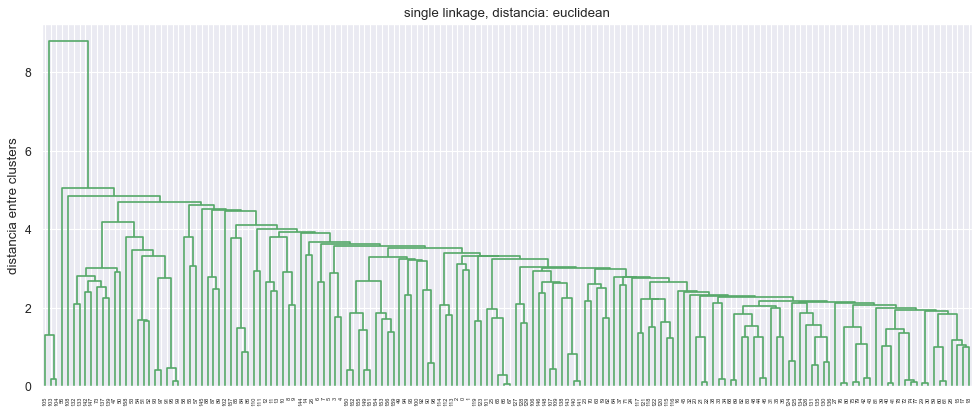

cantidad de clusters anidados: 159


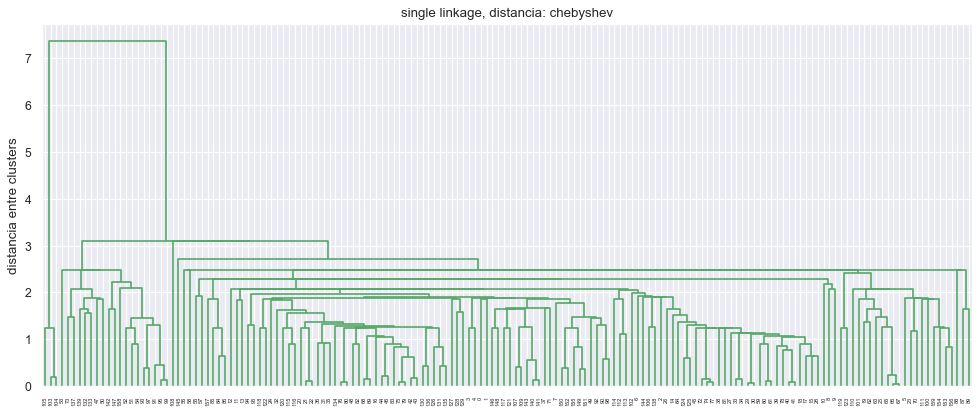

cantidad de clusters anidados: 159


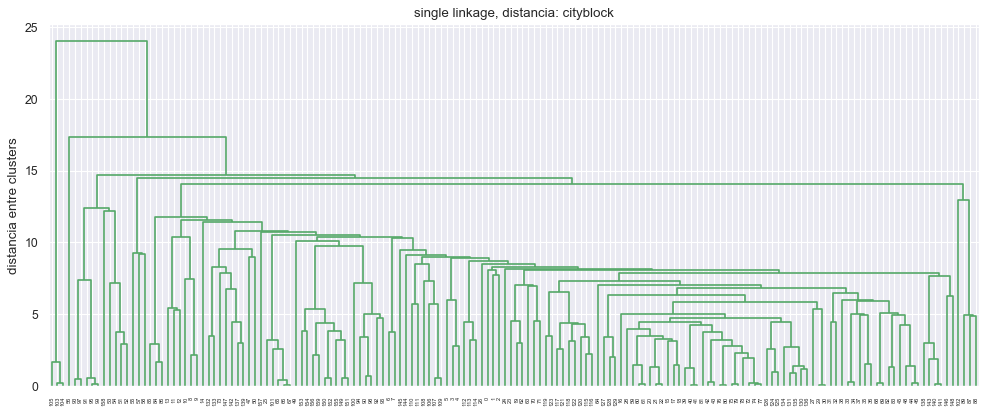

cantidad de clusters anidados: 159


In [8]:
%matplotlib inline
metriclist=['euclidean', 'chebyshev', 'cityblock']
for i in metriclist:
    res=sch.linkage(df_cars_norm.values, method='single', metric=i)
    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title('single linkage, distancia: '+i)
    plt.ylabel('distancia entre clusters')
    dendrogram = sch.dendrogram(res, color_threshold=res[-1][2]+1)
    plt.show()
    print('cantidad de clusters anidados: '+str(res.shape[0]))

Como se puede observar, single linkage tiende a agupar elementos uno por uno (al final podemos ver como de los dos clusters finales, uno de ellos solo tiene un registro), esto aunque no podamos asegurar sea incorrecto, no es util para el problema, puesto que en el caso de tener dos clusters (que significaria dos grupos de coches) tendria que reservarse un almacen solo para un coche en particular.

### 2. Complete linkage: la distancia entre dos clusters es la distancia entre sus puntos mas alejados
<br>
\begin{align}
d(u,v)=max(dist(u[i],v[j]))
\end{align}
<br>
para todo $i$ en el cluster $u$ y todo $j$ en el cluster $v$
<br>
<br>
Para este metodo, utilizaremos las siguientes distancias:
<ul>
    <li> distancia euclidea: longitud de la recta que une ambos puntos</li>
    <li> distancia de chevishev: distancia maxima de las diferencias de los puntos en cada eje (o columna para este caso)</li>
    <li> cityblock/manhattan suma de las diferencias de los puntos en cada eje</li>
</ul>

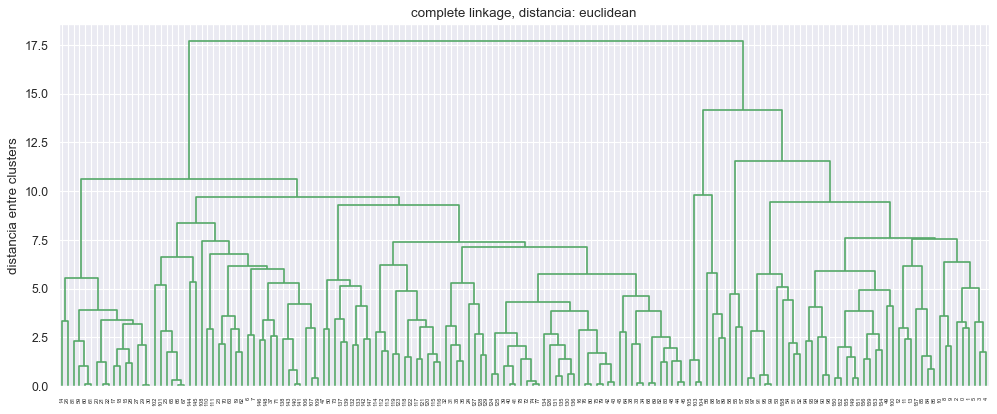

cantidad de clusters anidados: 159


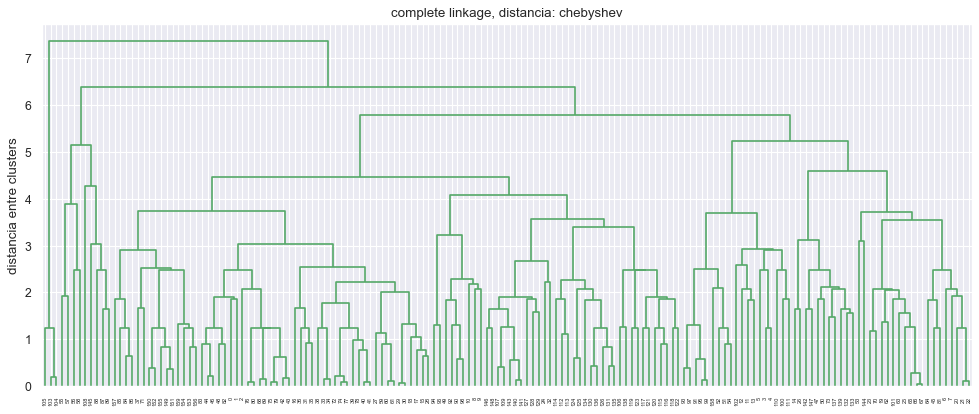

cantidad de clusters anidados: 159


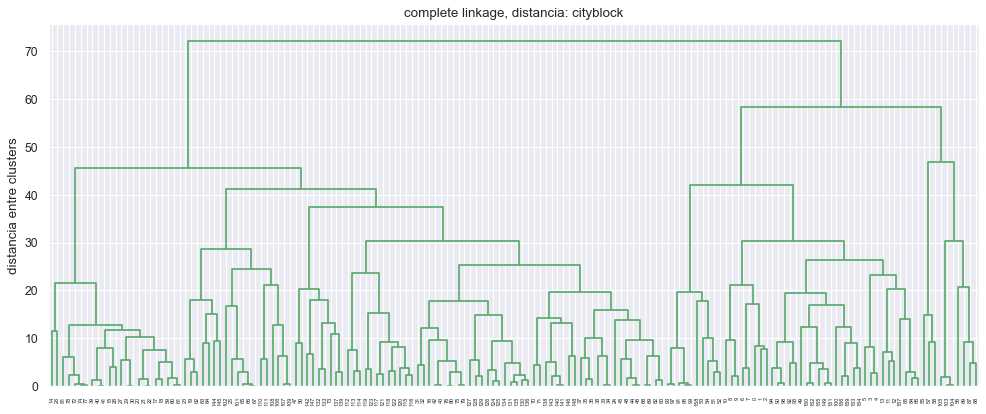

cantidad de clusters anidados: 159


In [9]:
for i in metriclist:
    res=sch.linkage(df_cars_norm.values, method='complete', metric=i)
    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title('complete linkage, distancia: '+i)
    plt.ylabel('distancia entre clusters')
    dendrogram = sch.dendrogram(res, color_threshold=res[-1][2]+1)
    plt.show()
    print('cantidad de clusters anidados: '+str(res.shape[0]))

Utilizando este metodo, podemos observar en los dendogramas generados entre 2 y 3 clusters, cada uno con una cantidad considerable de registros

### 3. Centroid linkage: la distancia entre dos clusters es la distancia entre sus centroides
<br>
\begin{align}
d(s,t)=||C_{s}-C_{t}||
\end{align}
<br>
donde $C_{s}$ y $C_{t}$ son los centroides de los clusters $s$ y $t$ respectivamente 
<br>
<br>
Para este metodo, utilizaremos la distancia euclidea


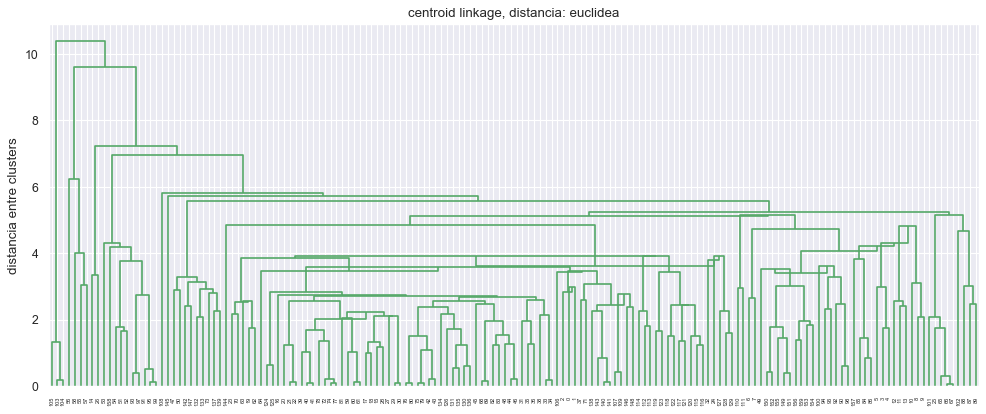

cantidad de clusters anidados: 159


In [10]:

res=sch.linkage(df_cars_norm.values, method='centroid', metric='euclidean')
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('centroid linkage, distancia: euclidea')
plt.ylabel('distancia entre clusters')
dendrogram = sch.dendrogram(res, color_threshold=res[-1][2]+1)
plt.show()
print('cantidad de clusters anidados: '+str(res.shape[0]))

Utilizando este metodo, podemos observar entre 2 y 3 clusters, aunque uno de ellos tiene pocos registros

### 4. Average linkage: la distancia entre dos clusters es la distancia promedio entre sus puntos
<br>
\begin{align}
d(u,v)=\sum_{ij}\frac{d(u[i],v[j])}{(|u|*|v|)}
\end{align}
<br>
para todos los puntos $i, j$ donde $|u|$ y $|v|$ son las cardinalidades de los clusters $u$ y $v$ respectivamente
<br>
<br>
Para este metodo, utilizaremos la distancia euclidea


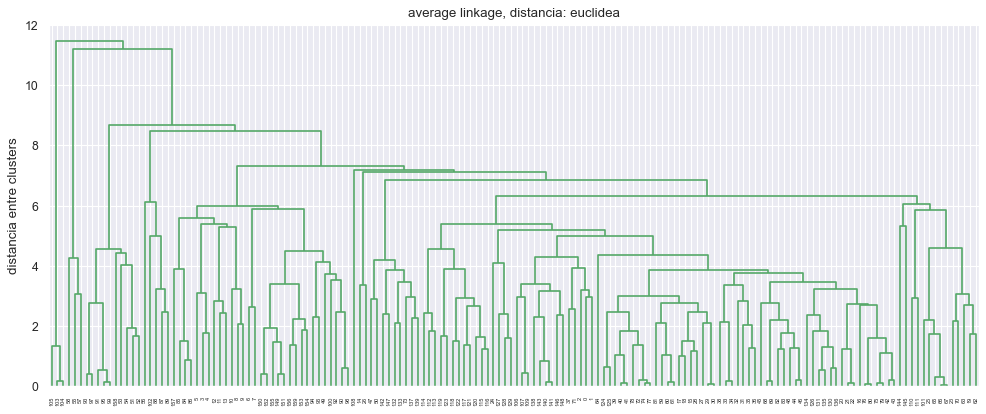

cantidad de clusters anidados: 159


In [11]:

res=sch.linkage(df_cars_norm.values, method='average', metric='euclidean')
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('average linkage, distancia: euclidea')
plt.ylabel('distancia entre clusters')
dendrogram = sch.dendrogram(res, color_threshold=res[-1][2]+1)
plt.show()
print('cantidad de clusters anidados: '+str(res.shape[0]))

el resultado de este modelo es bastante parecido al encontrado por single linkage

### 3. Ward linkage: la distancia se calcula con el algoritmo de minimización de varianza de Ward 
la nueva entrada $d(u,v)$ se calcula de la siguiente forma:
<br>
\begin{align}
d(u,v)=\sqrt{\frac{|v|+|s|}{T}d(v,s)^{2}+\frac{|v|+|t|}{T}d(v,t)^{2}-\frac{|v|}{T}d(s,t)^{2}}
\end{align}
<br>
donde $u$ es el cluster consistente de la union de los clusters $s$ y $t$, $v$ es un cluster sin usar en el "bosque", $T=|v|+|s|+|t|$, y $|*|$ es la cardinalidad de dicho argumento, este algoritmo tambien se conoce como <b>algoritmo incremental</b>
<br>
<br>
Para este metodo, utilizaremos la distancia euclidea


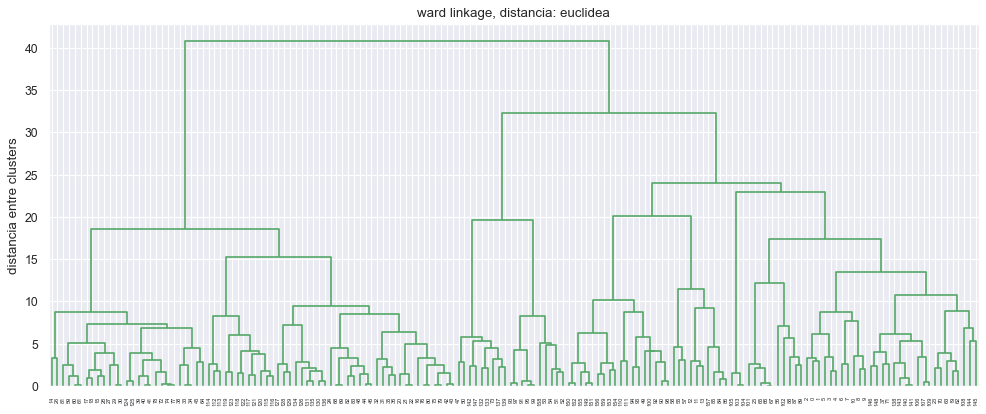

cantidad de clusters anidados: 159


In [12]:

res=sch.linkage(df_cars_norm.values, method='ward', metric='euclidean')
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('ward linkage, distancia: euclidea')
plt.ylabel('distancia entre clusters')
dendrogram = sch.dendrogram(res, color_threshold=res[-1][2]+1)
plt.show()
print('cantidad de clusters anidados: '+str(res.shape[0]))

Utilizando este metodo, podemos observar entre 3 y 4 clusters, cada uno con una cantidad considerable de registros.

## Selección del modelo final
A partir de los dendogramas generados, consideramos que el mejor método para la generación de clusters será utilizando el algoritmo de ward y distancia euclidea.


### Establecemos el límite de distancia entre clusters
un problema de el cluster jerárquico es no hay una forma objetiva de establecer cuantos clusters hay, se podría definir un único cluster, pues al final todos están agrupados, o bien se podría establecer todos los clusters desde el inicio, por lo que al utilizar el método aglomerativo la cantidad de clusters seria cercana al doble de la cantidad de registros, por lo que generalmente ara establecer la k en cluster jerárquico se hace uso de un límite de distancia entre clusters, a partir del cual no se considera la unión de estos dos.

revisando el dendograma, consideramos un límite es cercano a <b>24</b>

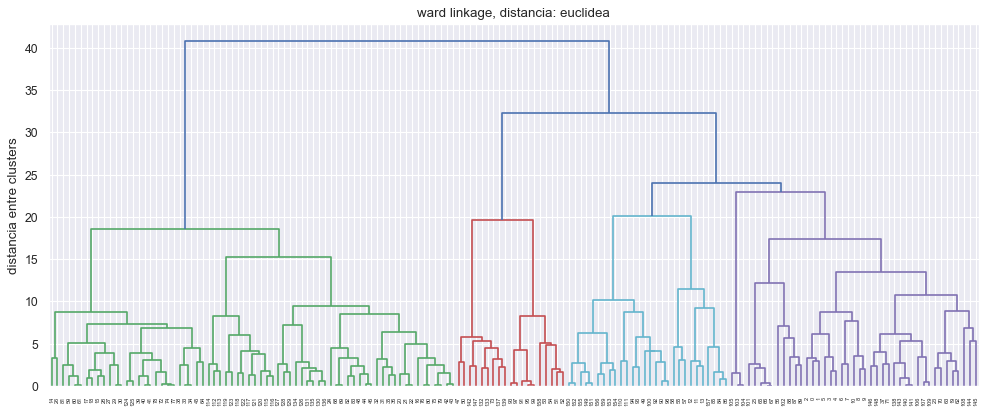

cantidad de clusters anidados: 159


In [13]:

res=sch.linkage(df_cars_norm.values, method='ward', metric='euclidean')
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('ward linkage, distancia: euclidea')
plt.ylabel('distancia entre clusters')
dendrogram = sch.dendrogram(res, color_threshold=24)
plt.show()
print('cantidad de clusters anidados: '+str(res.shape[0]))

### Para este caso, consideramos que la cantidad de clusters sera 4 (K=4)

## Generamos el modelo utilizando sklearn
Para este caso, establecemos el método, distancia y limite partir de lo visto en el apartado anterior


In [14]:
model = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=24)
model.fit(df_cars_norm)
print('cantidad de clusters encontrados: '+str(model.n_clusters_))
labels = model.labels_

cantidad de clusters encontrados: 4


## Asignamos el cluster a cada elemento para su analisis
a partir del dataset y "labels" del modelo

In [15]:
df_cars_norm['cluster']=labels
df_cars['cluster']=labels
display(df_cars_norm.head())

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,cluster
0,1.004901,1.404747,-1.775083,0.367086,-0.509748,0.774597,0.348273,-0.466252,-0.138233,0.142013,0.197284,0.124482,0.062512,-0.392495,-0.190133,-0.423606,-0.425886,0.953463,-0.498563,0.543094,-0.084526,0.033795,0.846815,-0.246741,-0.163959,0.080024,0
1,1.004901,1.404747,-1.775083,0.367086,-0.509748,0.774597,0.348273,-2.331262,-0.138233,0.077872,0.197284,0.216478,0.062512,0.543029,-0.190133,0.725156,0.272606,0.953463,-0.498563,0.543094,-0.547525,0.392438,0.846815,-1.154294,-1.298376,0.508881,0
2,1.004901,0.000000,-1.775083,0.367086,-0.509748,-1.290994,0.348273,-0.466252,-0.138233,0.142013,0.251335,0.170480,-0.448225,-0.065926,-0.190133,0.725156,0.272606,0.953463,-0.498563,0.543094,-0.431775,0.254499,0.846815,-1.003035,-0.872969,0.239314,0
3,0.180367,1.213353,-1.775083,0.367086,-0.509748,0.774597,0.348273,-0.466252,-0.138233,1.104134,1.440446,2.516374,0.658372,0.581449,-0.190133,0.725156,0.272606,0.953463,-0.498563,0.543094,-0.431775,0.254499,0.846815,-1.003035,-0.872969,0.540739,0
4,0.180367,0.000000,-1.775083,0.367086,-0.509748,0.774597,1.586575,-0.466252,-0.138233,1.104134,1.440446,2.516374,0.658372,0.792759,-0.190133,0.725156,0.272606,0.953463,-0.498563,0.543094,-0.431775,0.254499,0.846815,-1.003035,-0.872969,0.689001,0


In [16]:
#Cantidad de elementos en cada cluster
display(df_cars_norm.groupby(by='cluster').count()[['make']])

,make
cluster,
0,43
1,28
2,19
3,70


In [17]:
clusters=model.n_clusters_
pca = PCA(3) 
pca.fit(df_cars_norm.drop(columns=['cluster'])) 
  
pca_data = pd.DataFrame(pca.transform(df_cars_norm.drop(columns=['cluster']))) 
  
display(pca_data.head())
colors=np.array(['purple','blue','red','green'])


,0,1,2
0,-0.177141,0.817468,-0.080632
1,0.946499,1.588330,-0.638748
2,0.623875,1.924977,0.072303
3,2.623390,0.401446,-0.515831
4,2.734915,-0.222162,-1.093504


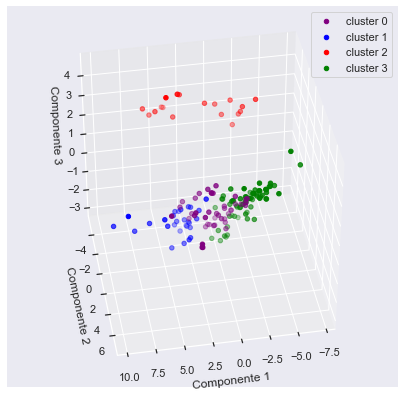

In [18]:
%matplotlib inline
fig = plt.figure(figsize=(7, 7)) 
ax = fig.add_subplot(111, projection = '3d') 
for i in range(4):
    index_list=np.nonzero(labels == i)
    comp1 = list(map(pca_data[0].__getitem__,index_list[0])) 
    comp2 = list(map(pca_data[1].__getitem__,index_list[0])) 
    comp3 = list(map(pca_data[2].__getitem__,index_list[0])) 
    ax.scatter(comp1, comp2, comp3,  c =colors[i] )
str_labels = list(map(lambda label:'% s' % label,labels))
ax.legend(['cluster 0','cluster 1','cluster 2','cluster 3'])
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
ax.view_init(40, 80)

Text(0, 0.5, 'Componente 2')

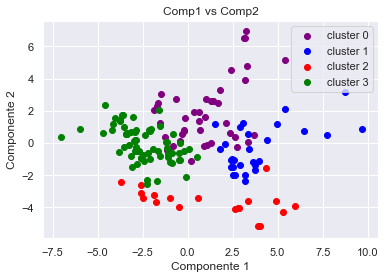

In [19]:
for i in range(4):
    index_list=np.nonzero(labels == i)
    comp1 = list(map(pca_data[0].__getitem__,index_list[0])) 
    comp2 = list(map(pca_data[1].__getitem__,index_list[0]))  
    plt.scatter(comp1, comp2,  c =colors[i] )
plt.title('Comp1 vs Comp2')
plt.legend(['cluster 0','cluster 1','cluster 2','cluster 3'])
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')



Text(0, 0.5, 'Componente 3')

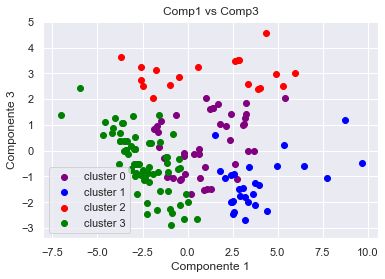

In [20]:
for i in range(4):
    index_list=np.nonzero(labels == i)
    comp1 = list(map(pca_data[0].__getitem__,index_list[0])) 
    comp3 = list(map(pca_data[2].__getitem__,index_list[0]))  
    plt.scatter(comp1, comp3,  c =colors[i] )
plt.title('Comp1 vs Comp3')
plt.legend(['cluster 0','cluster 1','cluster 2','cluster 3'])
plt.xlabel('Componente 1')
plt.ylabel('Componente 3')

Text(0, 0.5, 'Componente 3')

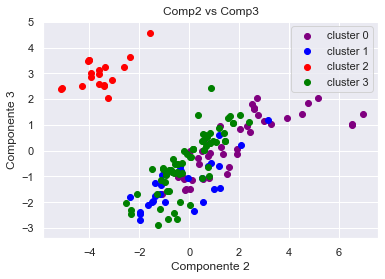

In [21]:
for i in range(4):
    index_list=np.nonzero(labels == i)
    comp1 = list(map(pca_data[1].__getitem__,index_list[0])) 
    comp3 = list(map(pca_data[2].__getitem__,index_list[0]))  
    plt.scatter(comp1, comp3,  c =colors[i] )
plt.title('Comp2 vs Comp3')
plt.legend(['cluster 0','cluster 1','cluster 2','cluster 3'])
plt.xlabel('Componente 2')
plt.ylabel('Componente 3')

## relaciones interesantes
Compararemos los valores continuos de los clusters encontrados, en busqueda de posibles diferencias entre ellos

### Comparación de variables fisicas

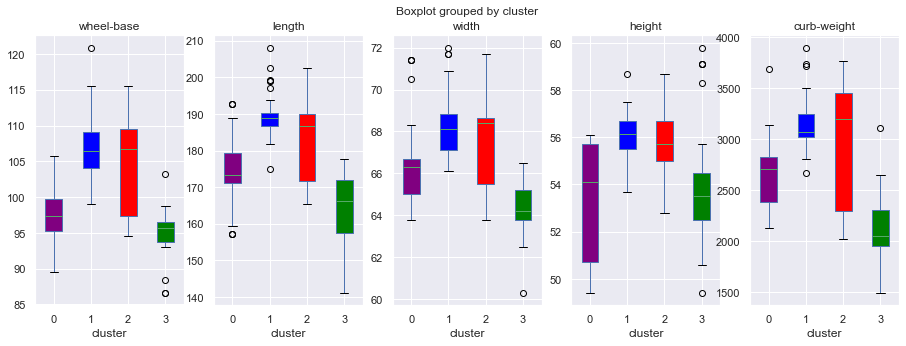

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
columns=['wheel-base','length','width','height','curb-weight']
for i in range(len(columns)):
    bp_dict = df_cars.boxplot(column=columns[i],by='cluster',return_type='dict',patch_artist = True,ax=ax[i])
    for row_key, (row) in bp_dict.iteritems():
        for i,box in enumerate(row['boxes']):
            box.set_facecolor(colors[i])


Como podemos notar, tanto el cluster 1 (azul) como el 3 (verde) muestran una gran diferencia respecto a sus ruedas, dimensiones fisicas y peso

### Comparación en variables técnicas


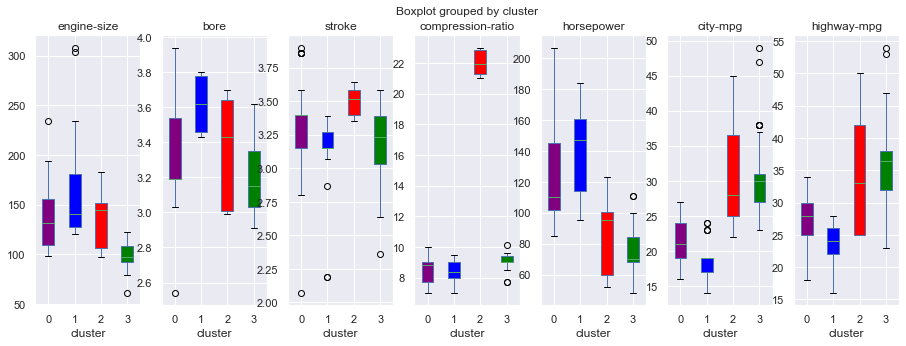

In [23]:
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
columns=['engine-size','bore','stroke','compression-ratio','horsepower','city-mpg','highway-mpg']
for i in range(len(columns)):
    bp_dict = df_cars.boxplot(column=columns[i],by='cluster',return_type='dict',patch_artist = True,ax=ax[i])
    for row_key, (row) in bp_dict.iteritems():
        for i,box in enumerate(row['boxes']):
            box.set_facecolor(colors[i])

Observamos una diferencia notable en la carrera de piston (stroke) entre los clusters 1 y 2, asi mismo podemos ver la gran diferencia en la relación de compresión del cluster 2 frente a los demas, por ultimo las millas por galon en ciudad en los clusters 0 y 1 es inferior a los registros de los coches en el cluster 2 y 3

## Comparación de precios

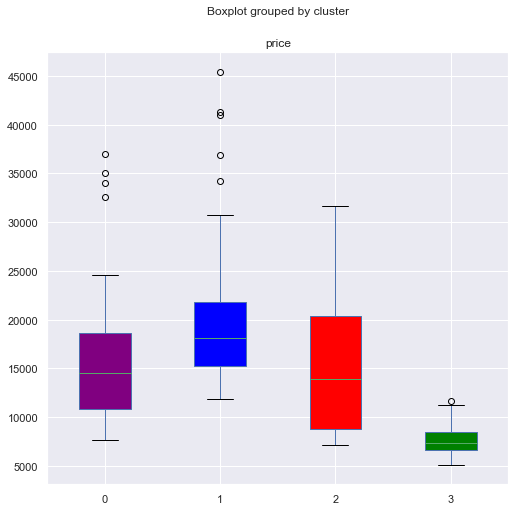

In [24]:
bp_dict = df_cars.boxplot(column=['price'],by='cluster',figsize=(8,8),return_type='both',patch_artist = True)
for row_key, (ax,row) in bp_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])

plt.show()

Los precios de los coches en el cluster 1 son en general mayores a los del cluster 3

### tipo de combustible

In [25]:
plt.close()
fabricantes=df_cars.groupby(by=['cluster','fuel-type']).count()[['symboling']].rename(columns={"symboling": "cantidad"})
display(fabricantes)


,,cantidad
cluster,fuel-type,
0,gas,43
1,gas,28
2,diesel,19
3,gas,70


Como podemos ver, en todos los clusters se tiene el mismo tipo de combustible, siendo el cluster 2 (rojo) el unico que tiene vehiculos con combustible diesel

## Conclusiones
Los clusters obtenidos realizaron un buen trabajo al agrupar los coches en 4 grupos, en donde cada uno cuenta con características particulares frente al resto, como por ejemplo en el cluster 1 vemos coches costosos y de grandes dimensiones físicas, bastantes caballos de potencia y un consumo elevado de combustible en ciudad frente al cluster 3, el cual se caracteriza por agrupar coches de precios reducidos y tamaños pequeños, con poca potencia pero un gran rendimiento de consumo, otro caso particular es el cluster 2 el cual agrupa coches a diesel con una relación de compresión elevado frente a todos los demás (esto debido a que los coches a diesel manejan relaciones elevadas para sacar mejor provecho del combustible)
